In [108]:
import dicom_contour.contour as dcm
import pathlib as Path
import numpy as np
%matplotlib inline


import tensorflow as tf
import keras
from keras import models
from keras import layers
from keras import optimizers

/Users/ianbenlolo/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [91]:
image_path = './Breast_MRI_cont/Joseph/'
contour_filename = 'RS.1.2.246.352.71.4.139189879485.219265.20180517150701.dcm'

In [92]:
rt_sequence = dicom.read_file(image_path+contour_filename)

In [93]:
print dcm.get_roi_names(rt_sequence)
print type(rt_sequence)

['GTV', 'Organ']
<class 'pydicom.dataset.FileDataset'>


In [94]:
def get_roi_contour_ds(rt_sequence, index):
    """
    Extract desired ROI contour datasets
    from RT Sequence.
    
    E.g. rt_sequence can have contours for different parts of the brain 
    such as ventricles, tumor, etc...
    
    You can use get_roi_names to find which index to use
    
    Inputs:
        rt_sequence (dicom.dataset.FileDataset): Contour file dataset, what you get 
                                                 after reading contour DICOM file
        index (int): Index for ROI Sequence
    Return:
        contours (list): list of ROI contour dicom.dataset.Dataset s
    """
    # index 0 means that we are getting RTV information
    ROI = rt_sequence.ROIContourSequence[index]
    # get contour datasets in a list
    contours = [contour for contour in ROI.ContourSequence]
    return contours

In [96]:
contour_datasets = get_roi_contour_ds(rt_sequence=rt_sequence, index=0)
print type(contour_datasets[0])

<class 'pydicom.dataset.Dataset'>


In [97]:
def contour2poly(contour_dataset, path):
    """
    Given a contour dataset (a DICOM class) and path that has .dcm files of
    corresponding images return polygon coordinates for the contours.

    Inputs
        contour_dataset (dicom.dataset.Dataset) : DICOM dataset class that is identified as
                         (3006, 0016)  Contour Image Sequence
        path (str): path of directory containing DICOM images

    Return:
        pixel_coords (list): list of tuples having pixel coordinates
        img_ID (id): DICOM image id which maps input contour dataset
        img_shape (tuple): DICOM image shape - height, width
    """

    contour_coord = contour_dataset.ContourData
    # x, y, z coordinates of the contour in mm
    coord = []
    for i in range(0, len(contour_coord), 3):
        coord.append((contour_coord[i], contour_coord[i + 1], contour_coord[i + 2]))

    # extract the image id corresponding to given countour
    # read that dicom file
    img_ID = contour_dataset.ContourImageSequence[0].ReferencedSOPInstanceUID
    img = dicom.read_file(path +'MR.'+ img_ID + '.dcm')
    img_arr = img.pixel_array
    img_shape = img_arr.shape
    
    # physical distance between the center of each pixel
    x_spacing, y_spacing = float(img.PixelSpacing[0]), float(img.PixelSpacing[1])

    # this is the center of the upper left voxel
    origin_x, origin_y, _ = img.ImagePositionPatient

    # y, x is how it's mapped
    pixel_coords = [(np.ceil((x - origin_x) / x_spacing), np.ceil((y - origin_y) / y_spacing))  for x, y, _ in coord]
    return pixel_coords, img_ID, img_shape
def poly_to_mask(polygon, width, height):
    from PIL import Image, ImageDraw
    
    """Convert polygon to mask
    :param polygon: list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
     in units of pixels
    :param width: scalar image width
    :param height: scalar image height
    :return: Boolean mask of shape (height, width)
    """

    # http://stackoverflow.com/a/3732128/1410871
    img = Image.new(mode='L', size=(width, height), color=0)
    ImageDraw.Draw(img).polygon(xy=polygon, outline=0, fill=1)
    mask = np.array(img).astype(bool)
    return mask
def get_mask_dict(contour_datasets, path):
    """
    Inputs:
        contour_datasets (list): list of dicom.dataset.Dataset for contours
        path (str): path of directory with images

    Return:
        img_contours_dict (dict): img_id : contour array pairs
    """
    
    from collections import defaultdict
    
    # create empty dict for 
    img_contours_dict = defaultdict(int)

    for cdataset in contour_datasets:
        coords, img_id, shape = contour2poly(cdataset, path)
        mask = poly_to_mask(coords, *shape)
        img_contours_dict[img_id] += mask
    
    return img_contours_dict
def parse_dicom_file(filename):
    """Parse the given DICOM filename
    :param filename: filepath to the DICOM file to parse
    :return: dictionary with DICOM image data
    """

    try:
        dcm = dicom.read_file(filename)
        dcm_image = dcm.pixel_array

        try:
            intercept = dcm.RescaleIntercept
        except AttributeError:
            intercept = 0.0
        try:
            slope = dcm.RescaleSlope
        except AttributeError:
            slope = 0.0

        if intercept != 0.0 and slope != 0.0:
            dcm_image = dcm_image*slope + intercept
        return dcm_image
    except dicom.errors.InvalidDicomError:
        return None

In [98]:
#the dictionary containing the slice -- mask information 
mask_dict = get_mask_dict(contour_datasets, image_path)

#get the orders the slices come in
slice_orders = dcm.slice_order(image_path)

In [99]:
def get_img_mask_voxel(slice_orders, mask_dict, image_path):
    """ 
    Construct image and mask voxels
    
    Inputs:
        slice_orders (list): list of tuples of ordered img_id and z-coordinate position
        mask_dict (dict): dictionary having img_id : contour array pairs
        image_path (str): directory path containing DICOM image files
    Return: 
        img_voxel: ordered image voxel for CT/MR
        mask_voxel: ordered mask voxel for CT/MR
    """
    
    img_voxel = []
    mask_voxel = []
    for img_id, _ in slice_orders:
        img_array = parse_dicom_file(image_path + 'MR.'+img_id + '.dcm')
        if img_id in mask_dict: mask_array = mask_dict[img_id]
        else: mask_array = np.zeros_like(img_array)
        img_voxel.append(img_array)
        mask_voxel.append(mask_array)
    return img_voxel, mask_voxel

In [100]:
img_data, mask_data = get_img_mask_voxel(slice_orders, mask_dict, image_path)

In [109]:
def get_data(image_path, contour_filename, roi_index):
    """
    Given image_path, contour_filename and roi_index return
    image and mask voxel array
    
    Inputs:
        image_path (str): directory path containing DICOM image files
        contour_filename (str): absolute filename for DICOM contour file
        roi_index (int): index for desired ROI from RT Struct
    Return:
        img_voxel (np.array): 3 dimensional numpy array of ordered images
        mask_voxel (np.array): 3 dimensional numpy array of ordered masks
    """
    # read dataset for contour
    rt_sequence = dicom.read_file(image_path+contour_filename)

    # get contour datasets with index idx
    contour_datasets = get_roi_contour_ds(rt_sequence, roi_index)

    # construct mask dictionary
    mask_dict = get_mask_dict(contour_datasets, image_path)

    # get slice orders
    slice_orders = dcm.slice_order(image_path)

    # get image and mask data for patient
    img_voxel, mask_voxel = get_img_mask_voxel(slice_orders, mask_dict, image_path)
    return img_voxel, mask_voxel
def show_img_msk_fromarray(img_arr, msk_arr, alpha=0.35, sz=7, cmap='inferno',
                           save_path=None):

    """
    Show original image and masked on top of image
    next to each other in desired size
    Inputs:
        img_arr (np.array): array of the image
        msk_arr (np.array): array of the mask
        alpha (float): a number between 0 and 1 for mask transparency
        sz (int): figure size for display
        save_path (str): path to save the figure
    """

    msk_arr = np.ma.masked_where(msk_arr == 0, msk_arr)
    plt.figure(figsize=(sz, sz))
    plt.subplot(1, 2, 1)
    plt.imshow(img_arr, cmap='gray')
    plt.imshow(msk_arr, cmap=cmap, alpha=alpha)
    plt.subplot(1, 2, 2)
    plt.imshow(img_arr, cmap='gray')
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close()

In [110]:
contour_data = dicom.read_file(image_path+contour_filename)

dcm.get_roi_names(contour_data)
img_voxel, mask_voxel = get_data(image_path, contour_filename, roi_index=0)

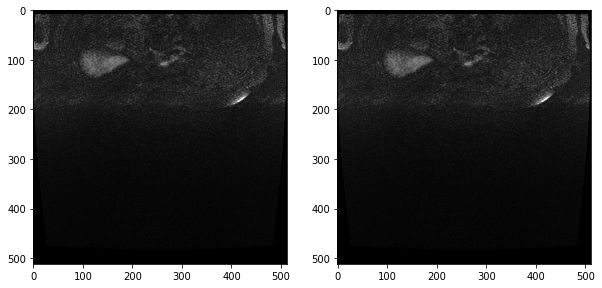

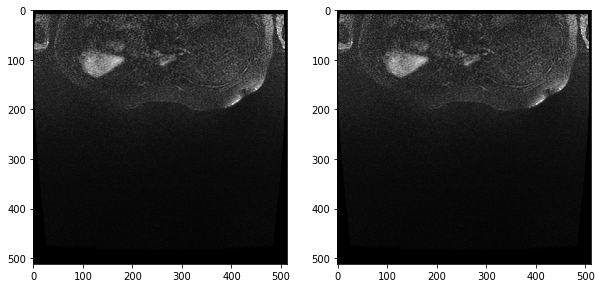

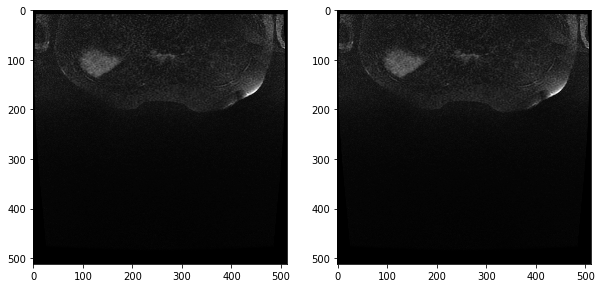

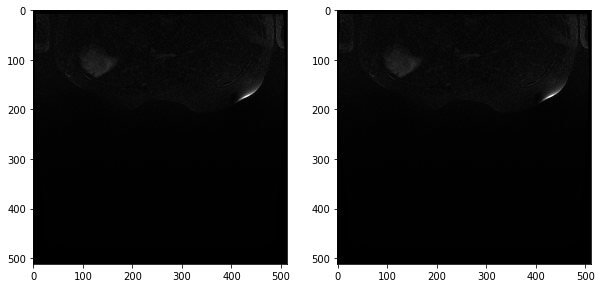

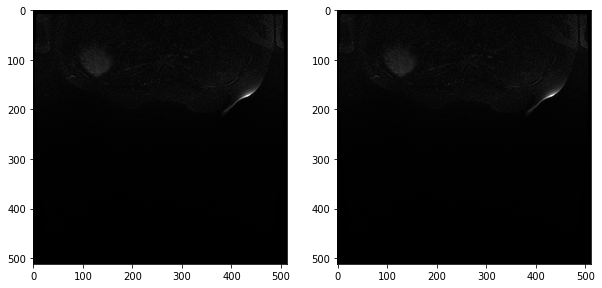

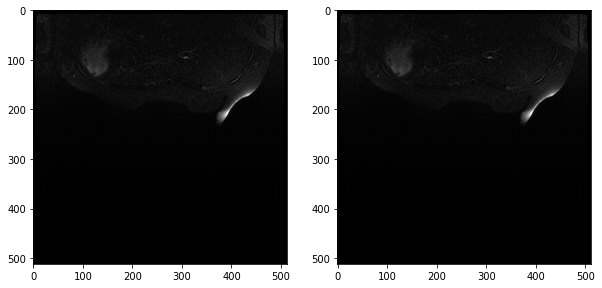

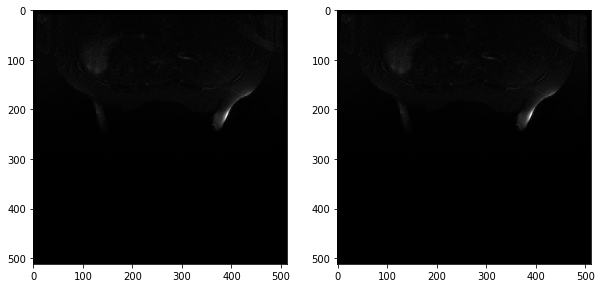

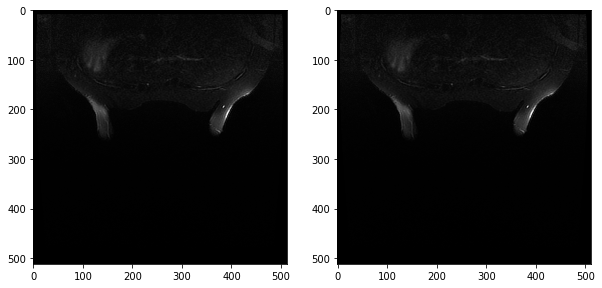

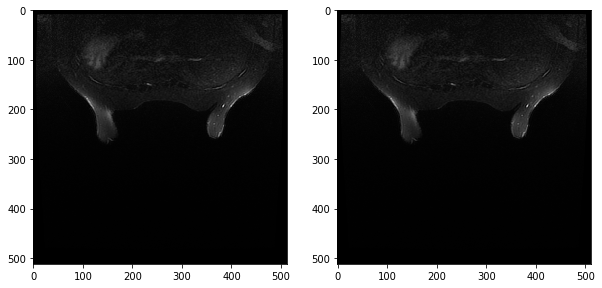

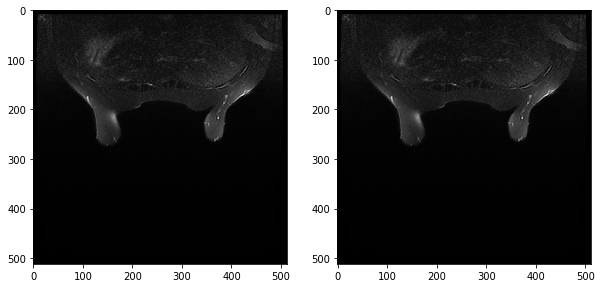

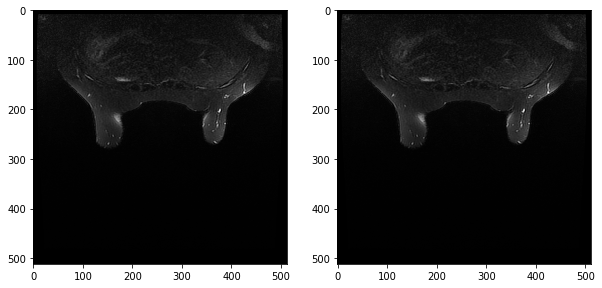

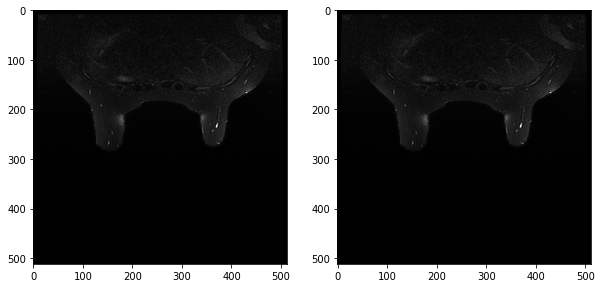

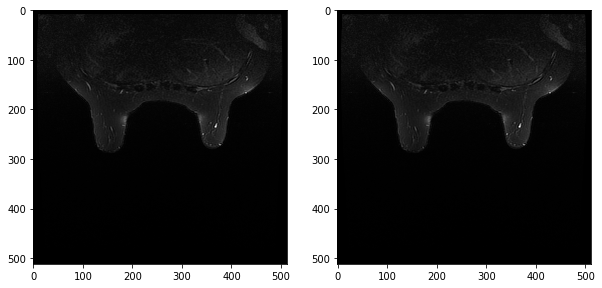

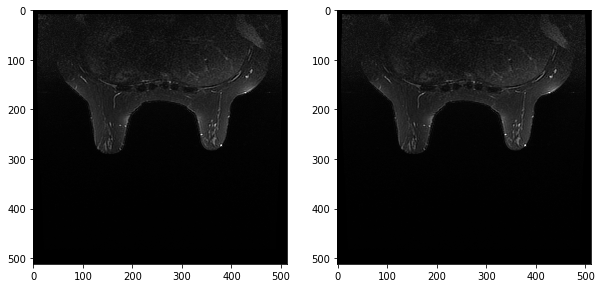

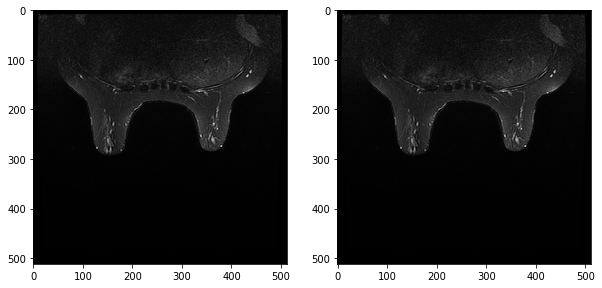

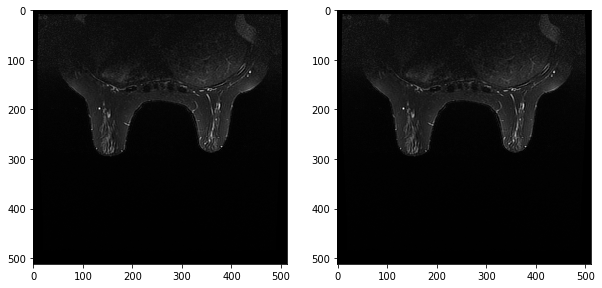

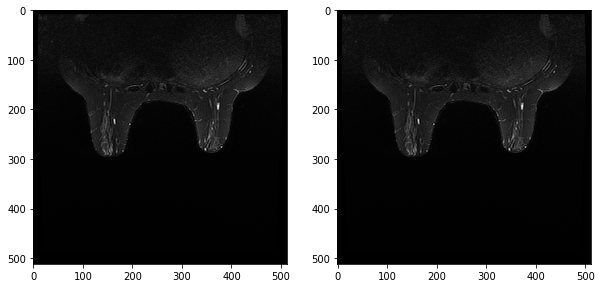

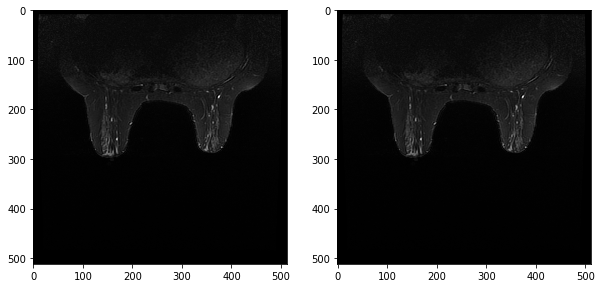

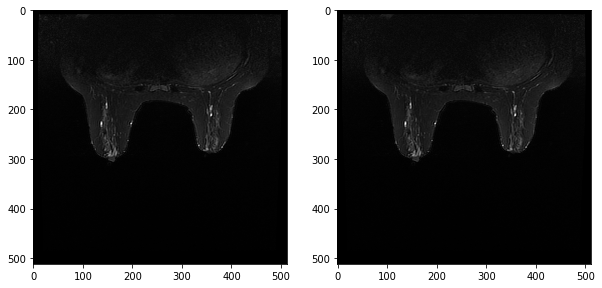

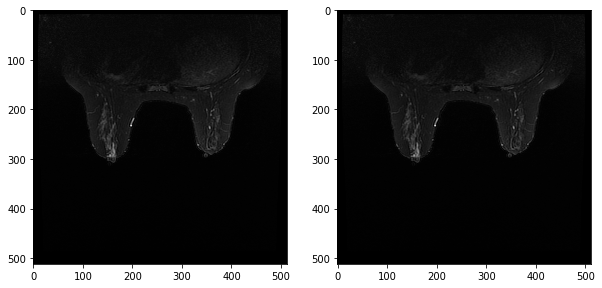

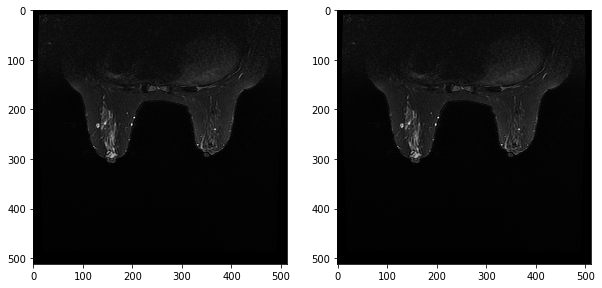

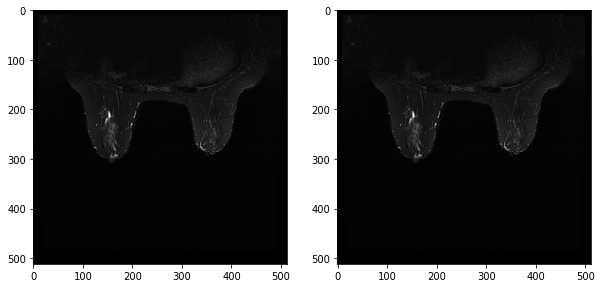

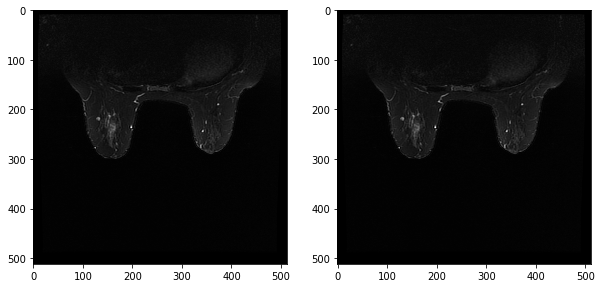

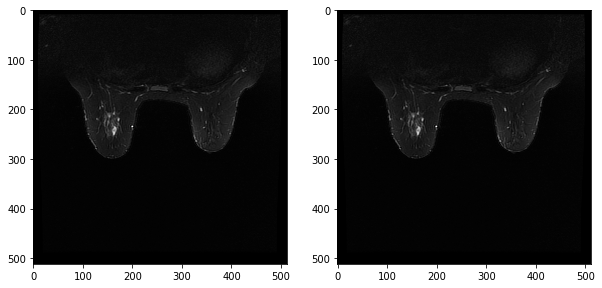

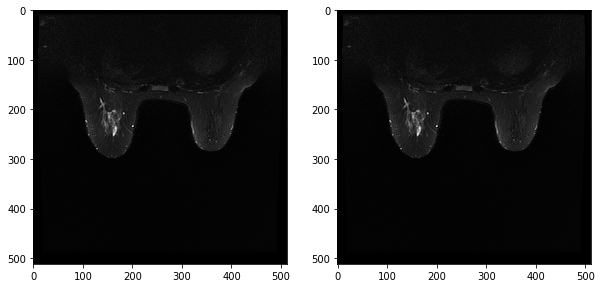

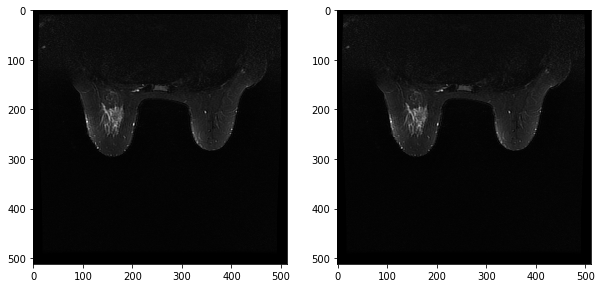

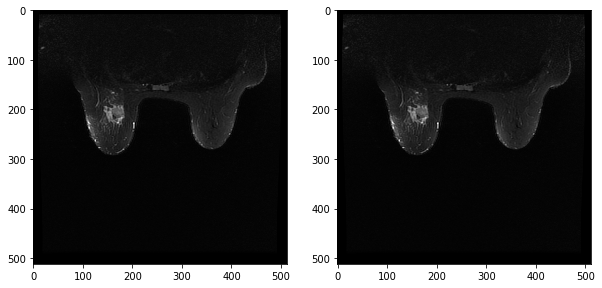

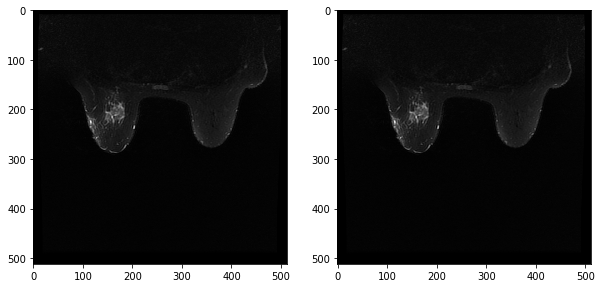

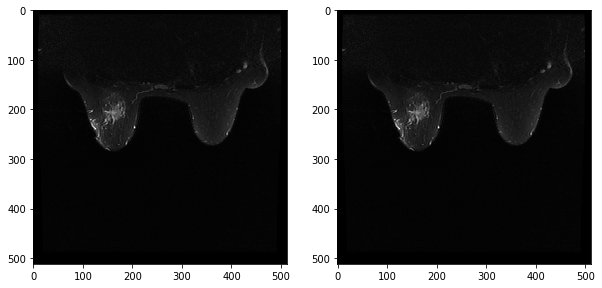

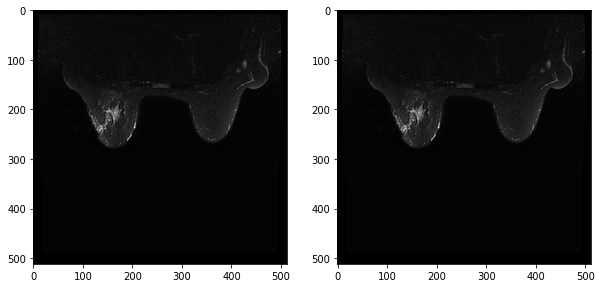

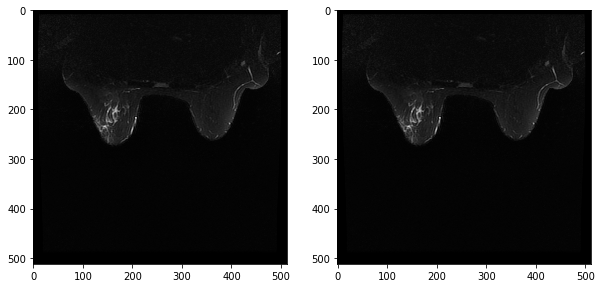

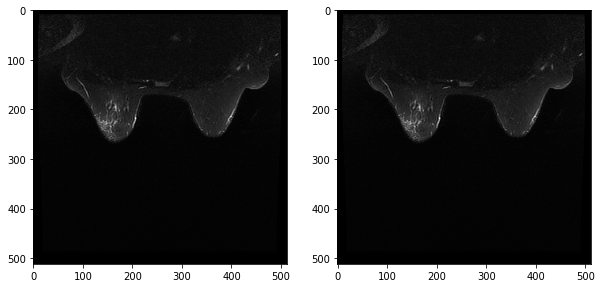

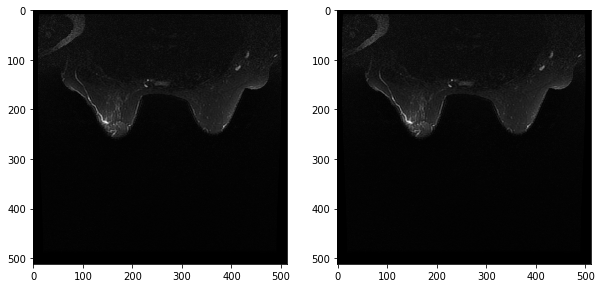

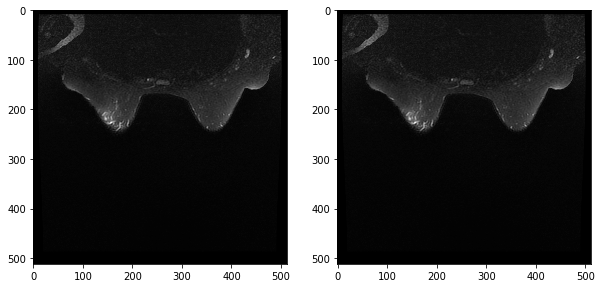

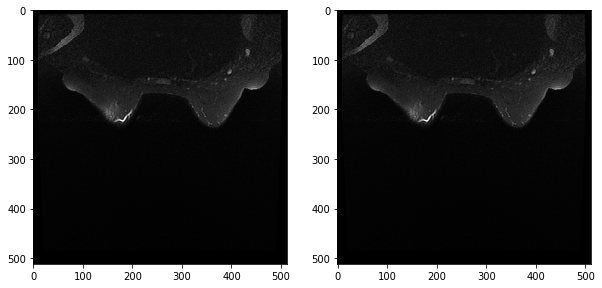

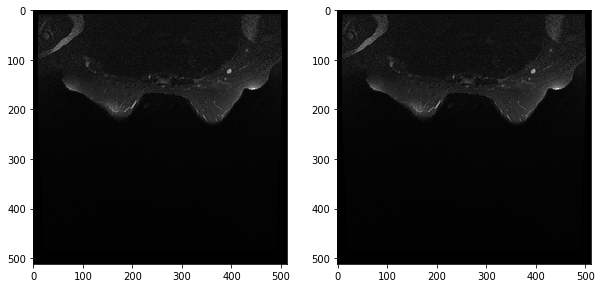

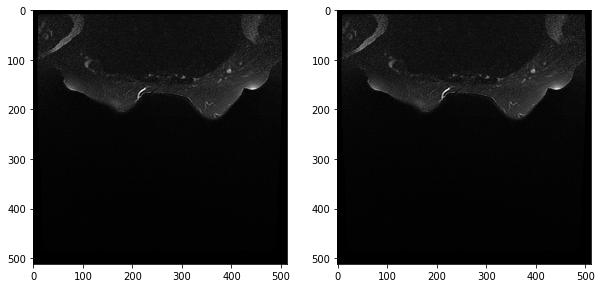

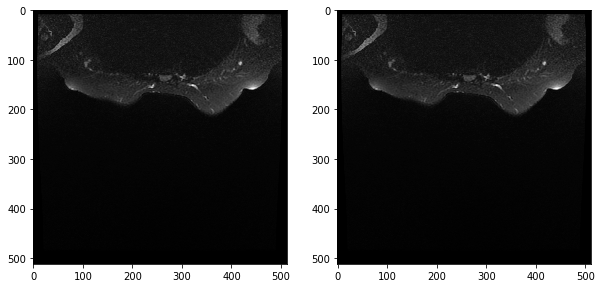

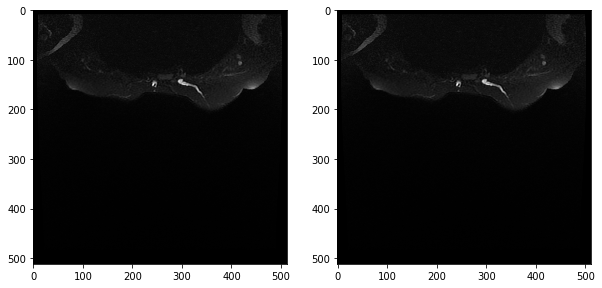

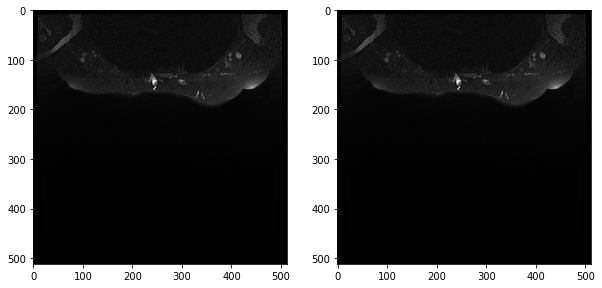

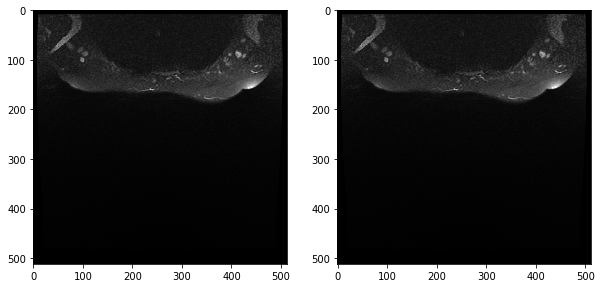

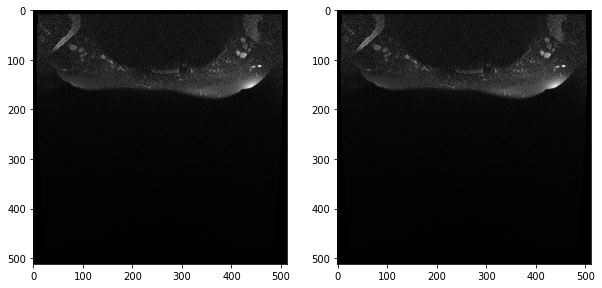

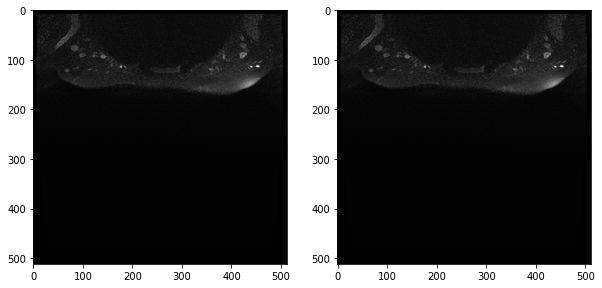

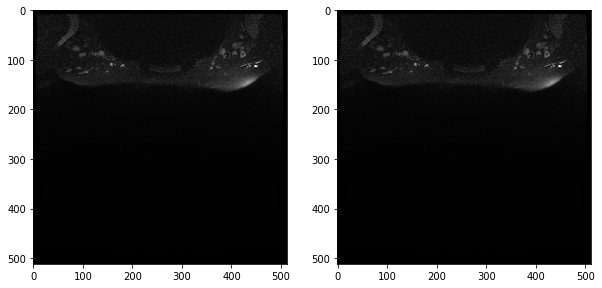

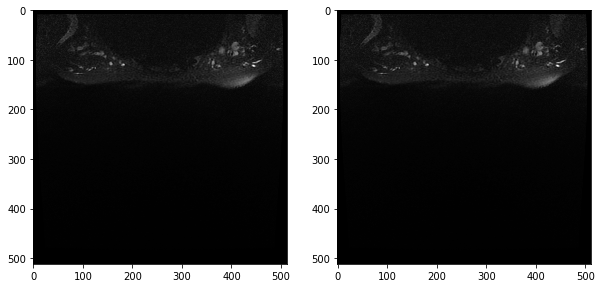

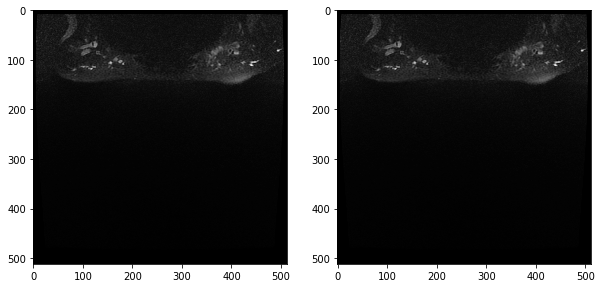

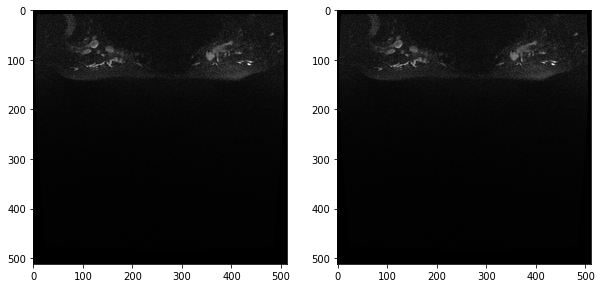

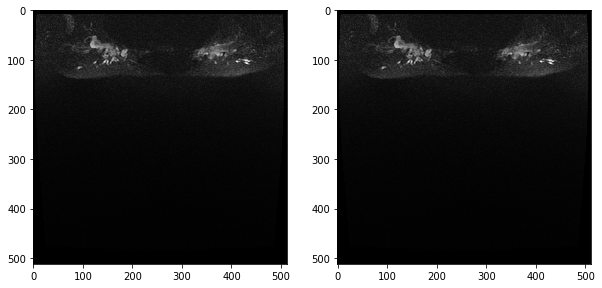

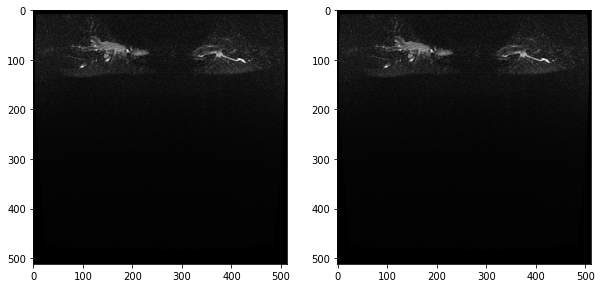

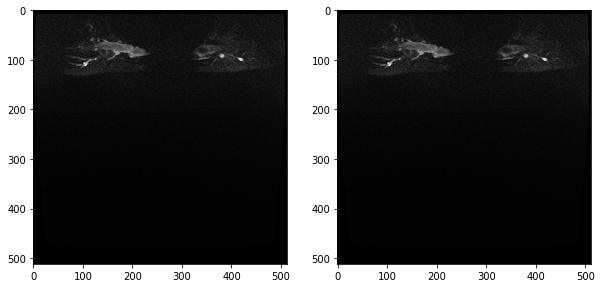

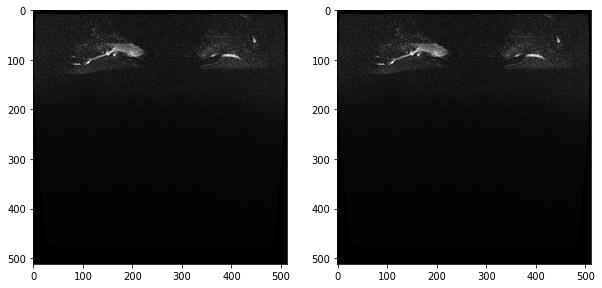

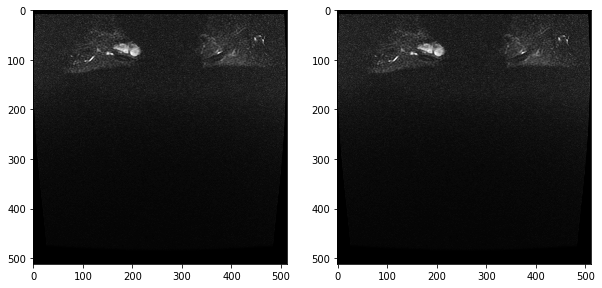

In [111]:
for img, mask in zip(img_voxel, mask_voxel):
    show_img_msk_fromarray(img, mask, sz=10, cmap='inferno', alpha=1)

## Create a simple model

Ill start with a simple one: one convolution, one average pooling and one fully connected layer. Well see where we go from there

In [112]:
def model(shape = (256,256)): # should i reshape to 64x64? 
    
    model = Sequential()
    
    model.add(Conv2D(100, (11,11), padding='valid', strides=(1, 1), input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(AveragePooling2D((6,6)))
    model.add(Reshape([-1, 8100]))
    model.add(Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Reshape([-1, 32, 32]))
    return model
